# コード4-1：時間遅れをもつ微分方程式の数値計算の実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

時間遅れをもつ微分方程式の数値計算の実装の例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み込み

In [89]:
## 必要があればインストール
# install.packages("ggplot2", "patchwork", "deSolve)

In [90]:
rm(list = ls(all = TRUE))
library(ggplot2)
library(patchwork)
library(deSolve)

## 時間遅れをもつ微分方程式

式(4.6)

$$
\frac{d T(t)}{dt} = - \beta T(t) V(t) \\
\frac{d I(t)}{dt} = \beta \int^{t}_{0}{f(a) T(t - a) V(t - a)} da - \delta I(t) \\
\frac{d V(t)}{dt} = p I(t) - c V(t)
$$

$f(a)$は式(4.3)

$$
f(a) = \mu_E(a) e^{- \int^{a}_{0}{\mu_E(s)}ds}
$$

### 固定遅れをもつ常微分方程式

$f(a)$がデルタ関数の場合、固定遅れを$\tau$とすると、

$$
\frac{d T(t)}{dt} = - \beta T(t) V(t) \\
\frac{d I(t)}{dt} = \beta T(t - \tau) V(t - \tau) - \delta I(t) \\
\frac{d V(t)}{dt} = p I(t) - c V(t)
$$

である。

ここでは`deSolve`ライブラリを用いて計算する。  
https://desolve.r-forge.r-project.org/

In [91]:
## 計算する時刻の設定
Tmin <- 0.0
Tmax <- 30.0
step_size <- 0.01

## パラメータの設定
## 1. lambda, d, beta, delta, p, c, T(0), I(0), V(0)
pars1 <- c(1.0*(10.0^-10.0), #beta
           0.5,               #delta
           3.0*(10.0^4.0),    #p
           2.0,               #c
           2.0,                #tau
           6.46*(10.0^6.0),   #T(0)
           10.0^-1.0,         #I(0)
           5.0*(10.0^4.0))    #V(0)

In [92]:
dde_derives <- function(t, y, parms) {
    
    beta <- parms[1]
    delta <- parms[2]
    p <- parms[3]
    c <- parms[4]
    tau <- parms[5]
    
    if (t < tau) {
        TClag <- parms[6]
        VLlag <- parms[8]
    } else {
        TClag <- lagvalue(t - 1, 1)
        VLlag <- lagvalue(t - 1, 3)
    }
    
    dTdt <- - beta * y[1] * y[3]
    dIdt <- beta * TClag * VLlag - delta * y[2]
    dVdt <- p * y[2] - c * y[3]
    
    return(list(c(dTdt, dIdt, dVdt)))
    
}

DDEs <- function(parms) {
    pars <- parms[1:8]

    ## 計算のタイムステップ
    t_list <- seq(Tmin, Tmax, by = step_size)
    ## 初期値 I(0), V(0)
    var_init <- c(TC = parms[6], IC = parms[7], VL = parms[8])
    ## 微分方程式の計算
    out <- dede(y = var_init, times = t_list, func = dde_derives, parms = pars)
    
    as.data.frame(out)
}

In [93]:
out1 <- DDEs(pars1)

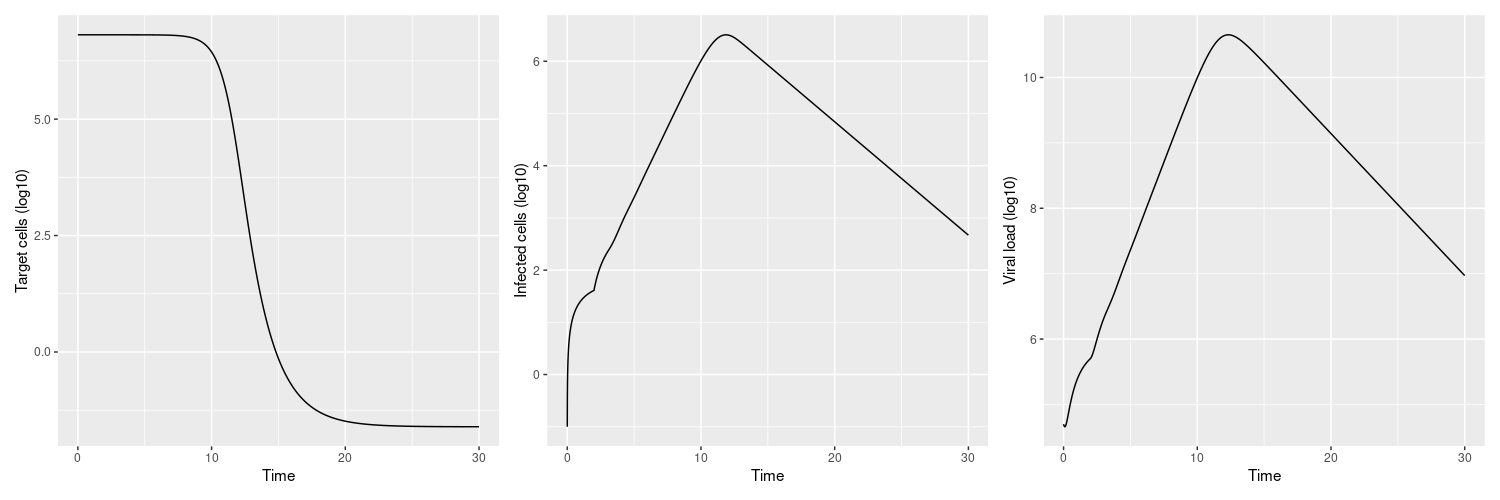

In [94]:
p1 <- ggplot(data = out1, aes(x = time, y = log10(TC))) +
    geom_line() +
    xlab("Time") +
    ylab("Target cells (log10)")

p2 <- ggplot(data = out1, aes(x = time, y = log10(IC))) +
    geom_line() +
    xlab("Time") +
    ylab("Infected cells (log10)")

p3 <- ggplot(data = out1, aes(x = time, y = log10(VL))) +
    geom_line() +
    xlab("Time") +
    ylab("Viral load (log10)")

options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定
p1 + p2 + p3

### 暗黒期細胞コンパートメントを含む式

$f(a)$が指数関数の場合、式(4.2)

$$
\frac{d T(t)}{dt} = g T(t) \left( 1 - \frac{T(t)}{T_{\text{max}}} \right) - \beta T(t) V(t) \\
\frac{d E(t)}{dt} = \beta T(t) V(t) - k E(t) \\
\frac{d I(t)}{dt} = k E(t) - \delta I(t) \\
\frac{d V(t)}{dt} = p I(t) - c V(t)
$$

において、細胞増殖項$g T(t) \left( 1 - \frac{T(t)}{T_{\text{max}}} \right)$がない場合の式

$$
\frac{d T(t)}{dt} = - \beta T(t) V(t) \\
\frac{d E(t)}{dt} = \beta T(t) V(t) - k E(t) \\
\frac{d I(t)}{dt} = k E(t) - \delta I(t) \\
\frac{d V(t)}{dt} = p I(t) - c V(t)
$$

である。

In [95]:
## 計算する時刻の設定
Tmin <- 0.0
Tmax <- 30.0
step_size <- 0.01

## beta, delta, p, c, k, T(0), I(0), V(0)
pars2 <- c(1.0*(10.0^-10.0), #beta
           0.5,               #delta
           3.0*(10.0^4.0),    #p
           2.0,               #c
           1/2.0,             #k
           6.46*(10.0^6.0),   #T(0)
           (10.0^-1.0),       #E(0)
           (10.0^-1.0),       #I(0)
           5.0*(10.0^4.0))   #V(0)

In [96]:
ode_derives <- function(t, var, pars) {
    with(as.list(c(var, pars)), {
        dTdt <- - beta * TC * VL
        dEdt <- beta * TC * VL - k * EC
        dIdt <- k * EC - delta * IC
        dVdt <- p * IC - c * VL
        
        return(list(c(dTdt, dEdt, dIdt, dVdt)))
    })
}

ODEs <- function(parms) {
    pars <- parms[1:5]
    names(pars) <- c("beta", "delta", "p", "c", "k")
    
    ## 計算のタイムステップ
    t_list <- seq(Tmin, Tmax, by = step_size)
    ## 初期値 I(0), V(0)
    var_init <- c(TC = parms[6], EC = parms[7], IC = parms[8], VL = parms[9])
    ## 微分方程式の計算
    out <- ode(y = var_init, times = t_list, func = ode_derives, parms = pars)
    
    as.data.frame(out)
}

In [97]:
out2 <- ODEs(pars2)

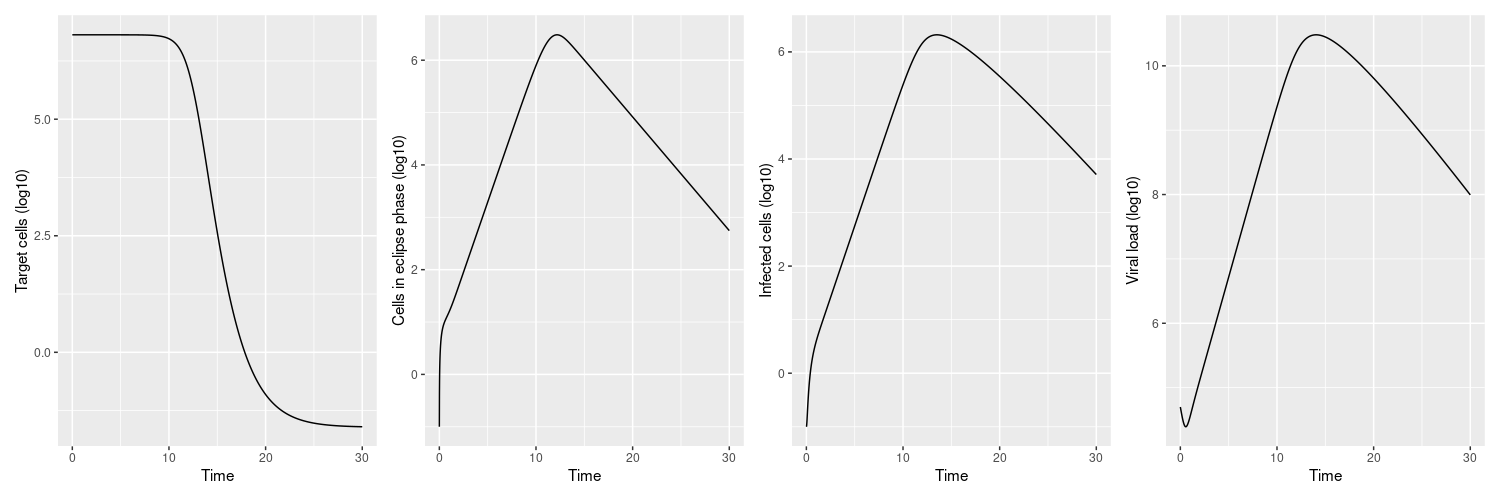

In [98]:
p1 <- ggplot(data = out2, aes(x = time, y = log10(TC))) +
    geom_line() +
    xlab("Time") +
    ylab("Target cells (log10)")

p2 <- ggplot(data = out2, aes(x = time, y = log10(EC))) +
    geom_line() +
    xlab("Time") +
    ylab("Cells in eclipse phase (log10)")

p3 <- ggplot(data = out2, aes(x = time, y = log10(IC))) +
    geom_line() +
    xlab("Time") +
    ylab("Infected cells (log10)")

p4 <- ggplot(data = out2, aes(x = time, y = log10(VL))) +
    geom_line() +
    xlab("Time") +
    ylab("Viral load (log10)")

options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定
p1 + p2 + p3 + p4 + plot_layout(nrow = 1)

### アーロン分布による近似

$n_E=3$の場合、$k=1,2,…,n_E$に対して、アーラン分布にしたがう分布遅れをもつ微分方程式(4.6)は式(4.7)

$$
\frac{d T(t)}{dt} = - \beta T(t) V(t) \\
\frac{d E_1(t)}{dt} = \beta T(t) V(t) - \frac{n_E}{\tau_E}E_1(t) \\
\frac{d E_2(t)}{dt} = \frac{n_E}{\tau_E} \left( E_1(t) - E_2(t) \right) \\
\frac{d E_3(t)}{dt} = \frac{n_E}{\tau_E} \left( E_2(t) - E_3(t) \right) \\
\frac{d I(t)}{dt} = \frac{n_E}{\tau_E} E_3(t) - \delta I(t) \\
\frac{d V(t)}{dt} = p I(t) - c V(t)
$$

の常微分方程式で書き下すことができる。

ここで$τ_E=0.98$である。

In [99]:
## 計算する時刻の設定
Tmin <- 0.0
Tmax <- 30.0
step_size <- 0.01

## beta, delta, p, c, k, T(0), I(0), V(0)
pars3 <- c(1.0*(10.0^-10.0),  #beta
           0.5,               #delta
           3.0*(10.0^4.0),    #p
           2.0,               #c
           3.0,               #n_E
           0.98,              #tau_E
           6.46*(10.0^6.0),   #T(0)
           (10.0^-1.0),       #E_1(0)
           (10.0^-1.0),       #E_2(0)
           (10.0^-1.0),       #E_3(0)
           (10.0^-1.0),       #I(0)
           5.0*(10.0^4.0))   #V(0)

In [100]:
ode_derives <- function(t, var, pars) {
    with(as.list(c(var, pars)), {
        dTdt <- - beta * TC * VL
        dE1dt <- beta * TC * VL - (n_E/tau_E) * EC1
        dE2dt <- (n_E/tau_E) * (EC1 - EC2)
        dE3dt <- (n_E/tau_E) * (EC2 - EC3)
        dIdt <- (n_E/tau_E) * EC3 - delta * IC
        dVdt <- p * IC - c * VL
        
        return(list(c(dTdt, dE1dt, dE2dt, dE3dt, dIdt, dVdt)))
    })
}

ODEs <- function(parms) {
    pars <- parms[1:6]
    names(pars) <- c("beta", "delta", "p", "c", "n_E", "tau_E")
    
    ## 計算のタイムステップ
    t_list <- seq(Tmin, Tmax, by = step_size)
    ## 初期値 I(0), V(0)
    var_init <- c(TC = parms[7], EC1 = parms[8], EC2 = parms[9], EC3 = parms[10],
                  IC = parms[11], VL = parms[12])
    ## 微分方程式の計算
    out <- ode(y = var_init, times = t_list, func = ode_derives, parms = pars)
    
    as.data.frame(out)
}

In [101]:
out3 <- ODEs(pars3)

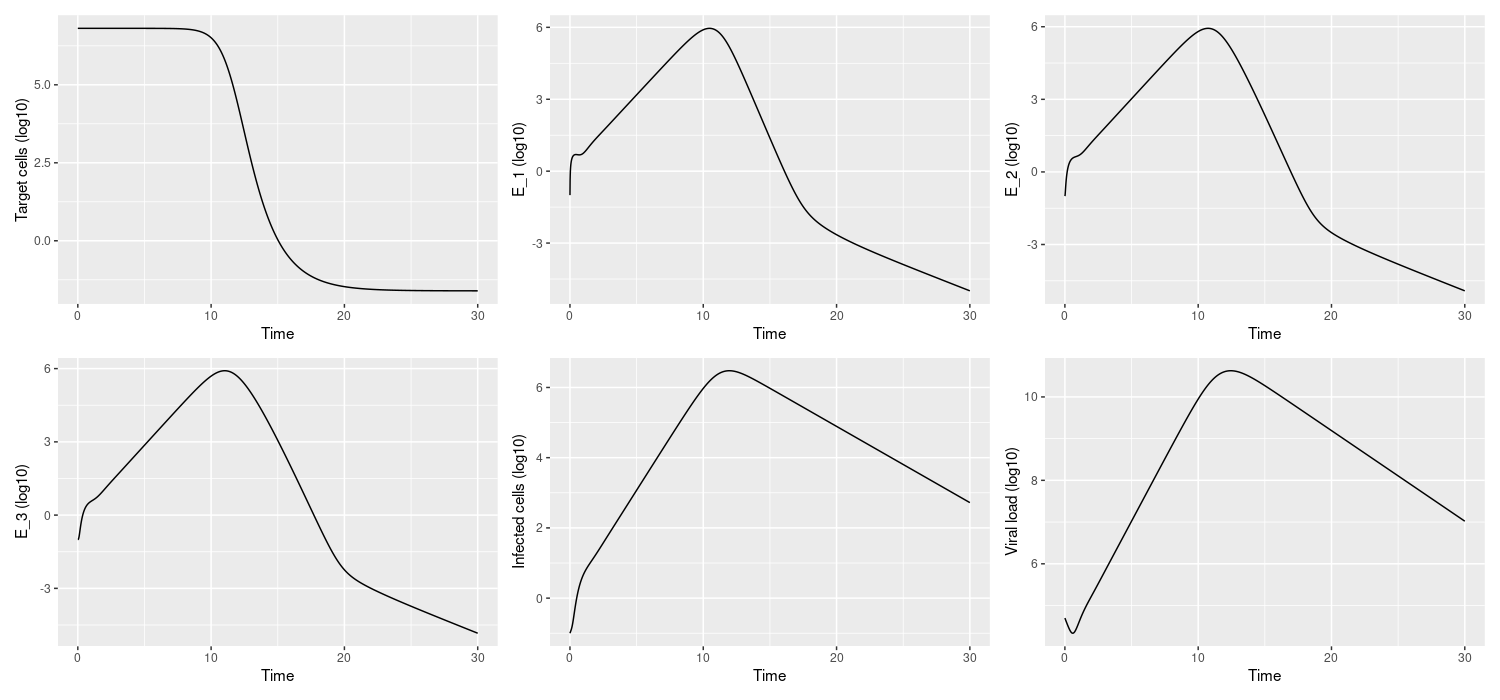

In [102]:
plt <- list()

for (i in 1:6) {
    
    data_temp <- out3[, c("time", colnames(out3)[-1][i])]
    colnames(data_temp) <- c("x", "y")
    
    ylabel <- c("Target cells (log10)", "E_1 (log10)", "E_2 (log10)",
                "E_3 (log10)", "Infected cells (log10)", "Viral load (log10)")[i]
    
    plt[[i]] <- ggplot(data = data_temp, aes(x = x, y = log10(y))) +
        geom_line() +
        xlab("Time") +
        ylab(ylabel)
}

options(repr.plot.width = 15, repr.plot.height = 7, repr.plot.res = 100) ## プロットの描画サイズの設定
wrap_plots(plt) + plot_layout(nrow = 2)

In [103]:
### SHIVシングルサイクル感染実験の定量的データ解析

In [104]:
## 計算する時刻の設定
Tmin <- 0.0
Tmax <- 3.0
step_size <- 0.01

## beta, delta, p, c, k, T(0), I(0), V(0)
pars4 <- c(1.0*(10.0^-10.0),  #beta
           14.0,              #delta
           3.26*(10.0^4.0),   #p
           0.039,             #c
           3.0,               #n_E
           0.98,              #tau_E
           0.0,               #T(0)
           (10.0^6.0),        #E_1(0)
           0.0,               #E_2(0)
           0.0,               #E_3(0)
           0.0,               #I(0)
           1.29*(10.0^9.0))   #V(0)

In [105]:
out4 <- data.frame()
for (i in 1:2) {
    pars4[2] <- c(1.57, 14.0)[i]
    
    out4 <- rbind(out4, cbind(ODEs(pars4), label = c("A", "B")[i]))
}

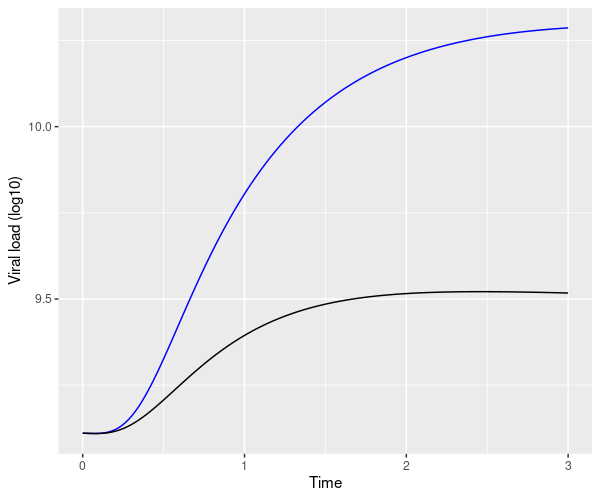

In [106]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定

ggplot(data = out4, aes(x = time, y = log10(VL), color = label)) +
    geom_line() +
    scale_color_manual(values = c(A = "blue", B = "black")) +
    xlab("Time") +
    ylab("Viral load (log10)") +
    theme(legend.position = 'none')